
--- Introducción ---
Este proyecto busca predecir si una carrera universitaria es de gestión estatal o privada
basándose en características generales como ubicación, modalidad, duración, nivel, temática, etc.
Se espera que estos resultados ayuden en la planificación estratégica educativa como por ejemplo nuevas universidades en lugares estrategicos.

Tipos de datos:
Provincia            object
Localidad            object
Modalidad            object
Duración            float64
Tipo de Duración     object
Nivel                object
Temática             object
tipo_gestion         object
dtype: object

Descripción estadística de variables numéricas:
          Duración
count  1504.000000
mean      4.162234
std       2.953894
min       1.000000
25%       3.000000
50%       4.000000
75%       5.000000
max      52.000000

Valores únicos por variable categórica:
- Provincia: 24 categorías
- Localidad: 81 categorías
- Modalidad: 2 categorías
- Tipo de Duración: 4 categorías
- Nivel: 6 categor

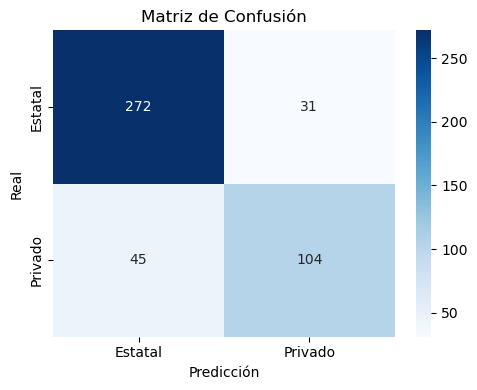


Accuracy promedio CV 5-fold: 0.7878781838316723

--- CONCLUSIONES ---
- El modelo logró una precisión promedio en validación cruzada de 78.79%.
- El desempeño general fue sólido, con mejoras posibles en la detección de carreras privadas.
- Las variables más importantes para la predicción fueron:
  ['Duración', 'Localidad_Ciudad Autonoma de Buenos Aires', 'Provincia_Ciudad Autonoma de Buenos Aires', 'Temática_Diseño', 'Temática_Medios', 'Nivel_Posgrado', 'Nivel_Grado', 'Nivel_Pregrado', 'Temática_Música', 'Localidad_Moron']
- Localidad con más universidades públicas: 'Ciudad Autonoma de Buenos Aires' (132 carreras)
- Localidad con menos universidades públicas: 'San Nicolas' (1 carrera/s)
- Para mejorar el recall en privadas, se sugiere explorar balanceo de clases y nuevos modelos.


In [34]:
# Fecha de entrega: 22/07/2025  
# Alumno: Emmanuel Pradines  
# Proyecto III

# --- Introducción ---
print("\n--- Introducción ---")
print("Este proyecto busca predecir si una carrera universitaria es de gestión estatal o privada")
print("basándose en características generales como ubicación, modalidad, duración, nivel, temática, etc.")
print("Se espera que estos resultados ayuden en la planificación estratégica educativa como por ejemplo nuevas universidades en lugares estrategicos.")


# --- Librerías ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import joblib


# --- Carga y limpieza de datos ---
df = pd.read_csv('carreras_universitarias.csv')

#print("\nPrimeras filas del dataset:")
#print(df.head())

#print("\nRevisión valores nulos por columna:")
#print(df.isnull().sum())

#print("\nCantidad de filas antes de eliminar duplicados:", df.shape[0])
df.drop_duplicates(inplace=True)
#print("Cantidad de filas después de eliminar duplicados:", df.shape[0])

# --- Selección de columnas relevantes ---
columnas_seleccionadas = [
    'Provincia', 'Localidad', 'Modalidad',
    'Duración', 'Tipo de Duración', 'Nivel',
    'Temática', 'tipo_gestion'
]
df_modelo = df[columnas_seleccionadas].copy()

# --- Exploración básica ---
print("\nTipos de datos:")
print(df_modelo.dtypes)

print("\nDescripción estadística de variables numéricas:")
print(df_modelo.describe())

print("\nValores únicos por variable categórica:")
for col in df_modelo.select_dtypes(include='object').columns:
    print(f"- {col}: {df_modelo[col].nunique()} categorías")

# --- Preprocesamiento ---
# Codificar variable objetivo: 0 estatal, 1 privada
df_modelo['tipo_gestion_privada'] = df_modelo['tipo_gestion'].apply(lambda x: 1 if x == 'Privado' else 0)
df_modelo.drop('tipo_gestion', axis=1, inplace=True)

# Separar variables numéricas y categóricas
num_cols = ['Duración']
cat_cols = [col for col in df_modelo.columns if col not in num_cols + ['tipo_gestion_privada']]

# Rellenar nulos numéricos si hay
df_modelo[num_cols] = df_modelo[num_cols].fillna(df_modelo[num_cols].median())

# Escalar numéricas
scaler = StandardScaler()
df_modelo[num_cols] = scaler.fit_transform(df_modelo[num_cols])

# Codificación One Hot para categóricas
df_modelo_encoded = pd.get_dummies(df_modelo, columns=cat_cols, drop_first=True)
print("\nDimensiones tras codificación:", df_modelo_encoded.shape)

# Variables predictoras y objetivo
X = df_modelo_encoded.drop('tipo_gestion_privada', axis=1)
y = df_modelo_encoded['tipo_gestion_privada']

# --- Selección de características ---
# Chi2 (solo para categóricas)
df_cat = pd.get_dummies(df_modelo.drop(num_cols, axis=1).drop('tipo_gestion_privada', axis=1), drop_first=True)
selector_chi2 = SelectKBest(score_func=chi2, k=10)
selector_chi2.fit(df_cat, y)
selected_features_chi2 = df_cat.columns[selector_chi2.get_support()]
print("\nCaracterísticas seleccionadas por Chi2:")
print(list(selected_features_chi2))

# Importancia por Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features_rf = importances.sort_values(ascending=False).head(10).index
print("\nTop 10 características por Random Forest:")
print(list(top_features_rf))

# Dataset final con features seleccionadas
X_selected = X[top_features_rf]

# --- División de datos ---
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42, stratify=y)

# --- Entrenamiento ---
modelo_final = RandomForestClassifier(random_state=42)
modelo_final.fit(X_train, y_train)

# --- Evaluación ---
y_pred = modelo_final.predict(X_test)
print("\nAccuracy en test:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

# --- Matriz de confusión ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Estatal','Privado'], yticklabels=['Estatal','Privado'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()

# --- Validación cruzada ---
cv_scores = cross_val_score(modelo_final, X_selected, y, cv=5, scoring='accuracy')
print("\nAccuracy promedio CV 5-fold:", cv_scores.mean())

# --- Análisis extra: Localidades ---
df_estatal = df[df['tipo_gestion'] == 'Estatal']
conteo_localidades = df_estatal['Localidad'].value_counts()

localidad_mas = conteo_localidades.idxmax()
cantidad_mas = conteo_localidades.max()
localidad_menos = conteo_localidades[conteo_localidades > 0].idxmin()
cantidad_menos = conteo_localidades[conteo_localidades > 0].min()
# --- Guardado del modelo ---
joblib.dump(modelo_final, 'modelo_carreras_rf.pkl')

# --- Conclusiones ---
print("\n--- CONCLUSIONES ---")
print("- El modelo logró una precisión promedio en validación cruzada de {:.2f}%.".format(cv_scores.mean()*100))
print("- El desempeño general fue sólido, con mejoras posibles en la detección de carreras privadas.")
print("- Las variables más importantes para la predicción fueron:\n ", list(top_features_rf))
print("- Localidad con más universidades públicas: '{}' ({} carreras)".format(localidad_mas, cantidad_mas))
print("- Localidad con menos universidades públicas: '{}' ({} carrera/s)".format(localidad_menos, cantidad_menos))
print("- Para mejorar el recall en privadas, se sugiere explorar balanceo de clases y nuevos modelos.")
